# NextGen Climate Campaign

|   About the script    |                                         |
| ----------- | --------------------------------------- |
| Last update |  Dec 4 2019 |
| Experiment  | Illinois Text Message Experiment by NextGen Climate  |
| Dataset     | Stata file provided: `nextgen_relay_sms_clean_vh.dta` |


|    Available covariates   |      |
| ----------- | --------------------------------------- |
| 42 Elections Turnout| from year 2000 to year 2014 (general, primary, municipal) |
|demographical Profile|  age, gender, race, party|
| Vote Propensity | predicted by logit regression using voting history |

In [1]:
# load libraries

# data cleaning and reshape
import pandas as pd
import numpy as np

# caculate standard error
from scipy.stats import sem

# regression
import statsmodels.api as sm
# regression use formualar
import statsmodels.formula.api as smf
# regression with clustered standard error
import econtools.metrics as mt

# plot display
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# supress warning inline
import warnings
warnings.filterwarnings('ignore')

# display latex and html table
from IPython.display import Latex
from IPython.display import HTML

In [2]:
!pwd

/Users/yy2633/Dropbox/Thesis (2019 Fall)/Analysis Code


In [5]:
#df = pd.read_csv('../../Machine Learing HTE/1_data/nga_il/nga_il_add.csv')

In [7]:
# Read Stata DTA file
import econtools
df = econtools.read('../../Machine Learing HTE/1_data/nga_il/nextgen_relay_sms_clean_vh.dta')

In [3]:
# set random seed to ensure the following code and result is replicable
np.random.seed(2019)

## Intervention Description

During the 2016 general election, NextGen Climate conducted an experiment to assess whether peer-to-peer texting is effective at increasing voter turnout. NextGen Climate randomly assigned 94,257 individuals to receive a text message encouraging them to vote and 94,229 to a control group that received no outreach from NextGen Climate through Relay, the program they used for peer-to-peer texting.

In [9]:
# Dimension of Data
df.shape

(188486, 146)

In [10]:
def p_latex(x, cap):
    latex_string = '\\begin{table}[ht]\\centering\n\\caption{' + cap +'}\n'  
    latex_string = latex_string+x.to_latex().\
    replace('\\toprule','\\hline\\hline\\\\[-1em]').\
    replace('\\bottomrule', '\\hline \\hline') +'\\end{table}'
    return Latex(latex_string)

In [11]:
# description of assignment and compliance
def f(x):
    d = {}
    d['Group Size'] = x['treat_binary'].count()
    d['Compliance Rate'] = ((x['treat_binary']==x['contacted']).sum())/x['contacted'].count()
    d['Proportion to Subject Pool'] =  x['contacted'].count()/df.shape[0] 

    return pd.Series(d, index=[ 'Group Size',
                               'Compliance Rate',
                               'Proportion to Subject Pool'])

In [12]:
df[['treat_binary',
    'contacted',
   'voted']].groupby('treat_binary').apply(f).rename_axis("Assignment").rename(index={0: 'control',
                                                                                         1: 'treatment'})

,Group Size,Compliance Rate,Proportion to Subject Pool
Assignment,,,
control,94229.0,0.999682,0.499926
treatment,94257.0,0.952523,0.500074


In [13]:
to_p = df[['treat_binary',
    'contacted',
   'voted']].groupby('treat_binary').apply(f).rename_axis("Assignment").rename(index={0: 'control',
                                                                                         1: 'treatment'})

In [14]:
p_latex(to_p, 'Non-compliance in NextGen Climate Campaign')

<IPython.core.display.Latex object>

In [15]:
# outcome missing by assignemnt and compliance
def f(x):
    d = {}
    d['Assignment Group'] =  x['contacted'].count()
    d['Outcome Available'] =  (x['voted'].isna()==False).sum()
    d['Outcome Available but non-compliance'] =  ((pd.isnull(x['voted'])==False) & (x['treat_binary']!=x['contacted'])).sum()
    d['Complaints'] = ((x['treat_binary']==x['contacted']).sum())
    d['Outcome Mising Complaints'] = (pd.isnull(x['voted']) & (x['treat_binary']==x['contacted'])).sum()
    d['Complaints Outcome Available'] = ((pd.isnull(x['voted'])==False) & (x['treat_binary']==x['contacted'])).sum()

    return pd.Series(d, index=[ 'Assignment Group',
                               'Outcome Available',
                               'Outcome Available but non-compliance',
                               'Complaints',
                               'Outcome Mising Complaints',
                              'Complaints Outcome Available'])

df[['treat_binary',
    'contacted',
   'voted']].groupby('treat_binary').apply(f).rename_axis("Assignment").rename(index={0: 'control',
                                                                                         1: 'treatment'})

,Assignment Group,Outcome Available,Outcome Available but non-compliance,Complaints,Outcome Mising Complaints,Complaints Outcome Available
Assignment,,,,,,
control,94229,94229,30,94199,0,94199
treatment,94257,94257,4475,89782,0,89782


Overall, we find that 32.50% of the treatment group voted while 32.26% of the control group did.

In [16]:
# Turnout Comparison by Assignment
# Subjects without turnout record are dropped
df[df.voted.isna()==False][['treat_binary','contacted','voted']]. \
groupby('treat_binary')["voted"].\
agg({'Turnout Rate':'mean',
    'Assignment Group': 'count'}).\
rename_axis("Assignment").\
rename(index={0: 'control',1: 'treatment'})

,Turnout Rate,Assignment Group
Assignment,,
control,0.322586,94229
treatment,0.324994,94257


In [17]:
to_p = df[df.voted.isna()==False][['treat_binary','contacted','voted']]. \
groupby('treat_binary')["voted"].\
agg({'Turnout Rate':'mean',
    'Assignment Group': 'count'}).\
rename_axis("Assignment").\
rename(index={0: 'control',1: 'treatment'})

In [18]:
p_latex(to_p, 'Turnout Comparison in NextGen Climate')

<IPython.core.display.Latex object>

## Vote Propensity: The probability of voting based on vote history

In [20]:
# dummy variables for demographical covariates
for c in ['party', 'sex', 'racename']:
    drop_level = c+'_'+df[c].unique()[0]    
    dummy=pd.get_dummies(df[c],prefix=c).drop(labels=drop_level,axis=1)
    df=pd.concat([df,dummy], axis=1)

In [21]:
vote_list = ['aprilmuniprimary13','aprilmunicipal13','aprilmunicipal09', 'aprilmunicipal07', 'aprilmunicipal05',
 'aprilmunicipal03','febmunicipal15','febmunicipal11','febmunicipal09','febmunicipal07','febmunicipal05',
 'febmunicipal03','general14','general12','general10','general08','general06','general04','general02','general00',
 'municipal15','municipal09','municipal07','municipal05','municipal03','municipal01','municipalprimary15',
 'municipalrunoff15','presprimary08','presprimary04','presprimary00','primary16','primary14','primary12','primary10',
 'primary08','primary06','primary04','primary02','primary00','specialprimary15','specialprimary13','party_',
 'party_D',
 'party_R',
 'sex_F',
 'sex_U',
 'racename_African-American',
 'racename_Caucasian',
 'racename_Central Asian',
 'racename_East Asian',
 'racename_Hispanic',
 'racename_Jewish',
 'racename_Middle Eastern',
 'racename_Native American',
 'racename_Pacific Islander',
 'racename_South Asian']

In [22]:
pro_data = df.loc[:,[ 'treat_binary','voted', *vote_list]]

In [23]:
y = pro_data[pro_data.treat_binary==0].voted.astype(int)

In [24]:
X = pro_data[pro_data.treat_binary==0].loc[:,'aprilmuniprimary13':]

In [25]:
# Creat interaction term between vote histories
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_in = poly.fit_transform(X)

In [26]:
from sklearn.linear_model import LogisticRegression
#Note: logistic regression in sklearn is preset to be a regularization model with C=100).
# C is the tuning parameter like alpha in Reidge and Lasso regression Reguilization
logreg = LogisticRegression(C=1e90).fit(X_in, y)

In [27]:
all_in=poly.fit_transform(pro_data.loc[:,'aprilmuniprimary13':])

In [28]:
vp = logreg.predict_proba(all_in)

In [29]:
vp_df = pd.DataFrame(data={'vote_propensity': vp[:,1]}, index = pro_data.index)

In [30]:
df.drop(columns = [ 'vote_propensity', 'vp_10'], inplace = True)

KeyError: "['vote_propensity' 'vp_10'] not found in axis"

In [31]:
df = pd.merge(df, vp_df,left_index=True,
    right_index=True,how='left')

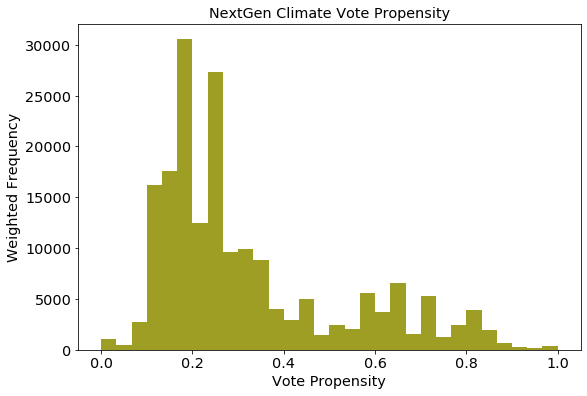

In [40]:
import matplotlib.pylab as pylab
params = {
        'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
plt.figure(figsize=(9,6))
ax = plt.hist(df.vote_propensity, 
         30,color='#9e9d24')
plt.xlabel("Vote Propensity")
plt.ylabel("Weighted Frequency")
plt.title("NextGen Climate Vote Propensity") # You can comment this line out if you don't need title
plt.show(ax)

In [33]:
# Cut vote propensity score into 10 bins
df['vp_10']=pd.cut(df.vote_propensity, np.arange(0,1.1,0.1))

In [34]:
def get_bins_table():
    pd.options.display.float_format = '{:.3%}'.format
    a = df[['vp_10','voted','treat_binary']].\
    groupby(['vp_10',"treat_binary"]). \
    voted.agg([('Size','count'),
              ('Turnout',np.mean),
              ('Proportion', lambda x: x.count()/df[df.vote_propensity.isna()==False].shape[0])]).reset_index()
    
    b = df[['vp_10','voted','treat_binary']].\
    groupby(['vp_10',"treat_binary"]). \
    voted.agg([('Size','count'),
              ('Turnout',np.mean)]).reset_index().groupby('vp_10').Turnout.agg([('Effect','diff')])
    
    r = pd.concat([a,b], axis=1)
    r.rename(columns={'vp_10': 'Vote Propensity Range'}, inplace = True)
    r.Effect.fillna(" ", inplace=True)
    r.treat_binary.replace([0,1],['Control', 'Treatment'], inplace=True)
    return r
  

In [35]:
get_bins_table()

,Vote Propensity Range,treat_binary,Size,Turnout,Proportion,Effect
0,"(0.0, 0.1]",Control,2169,5.855%,1.151%,
1,"(0.0, 0.1]",Treatment,2159,14.266%,1.145%,8.411%
2,"(0.1, 0.2]",Control,32120,15.342%,17.041%,
3,"(0.1, 0.2]",Treatment,32202,15.844%,17.085%,0.501%
4,"(0.2, 0.3]",Control,24712,25.186%,13.111%,
5,"(0.2, 0.3]",Treatment,24618,25.416%,13.061%,0.230%
6,"(0.3, 0.4]",Control,11364,34.468%,6.029%,
7,"(0.3, 0.4]",Treatment,11439,34.959%,6.069%,0.491%
8,"(0.4, 0.5]",Control,4748,45.451%,2.519%,
9,"(0.4, 0.5]",Treatment,4690,43.710%,2.488%,-1.741%


In [43]:
def p_latex(x, cap):
    latex_string = '\\begin{table}[ht]\\centering\n\\caption{' + cap +'}\n'  
    latex_string = latex_string+x.to_latex(index=False).\
    replace('\\toprule','\\hline\\hline\\\\[-1em]').\
    replace('\\bottomrule', '\\hline \\hline') +'\\end{table}'
    return Latex(latex_string)

In [45]:
p_latex(get_bins_table(),'Crosstable of Vote Propensity and Turnout in NextGen Climate')

<IPython.core.display.Latex object>

In [44]:
# Vote trunout by vote propensity socre and treatment assignment
Latex(get_bins_table().to_latex())

<IPython.core.display.Latex object>

## Balance Check

In [164]:
# display and export regression table
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
from IPython.display import Latex
prob_balance = []

In [165]:
prob_balance = []
prob_balance.append(smf.ols(formula='treat_binary ~ vote_propensity ', data=df).fit())


In [166]:

for var in ['party', 'sex', 'racename']:
    formular = 'treat_binary ~ C('+var+')'
    model = smf.ols(formular , df)
    results = model.fit()
    prob_balance.append(results)

In [167]:
prob_balance.append(smf.ols('treat_binary ~vote_propensity+C(party)+C(sex)+C(racename)', data=df).\
fit(cov_type='cluster',cov_kwds={'groups':df['hh_id']}))

In [168]:
stargazer = Stargazer(prob_balance)
stargazer.significant_digits(4)
stargazer.title('Balance Check')
stargazer.custom_columns(['vote propensity','party', 'sex', 'race', 'all'], [1,1,1,1,1])

HTML(stargazer.render_html())

In [37]:
df.to_csv('../../Machine Learing HTE/1_data/nga_il/nga_il_add.csv', index=False)

## Main Result

### OLS (without covariates, clustered SE)

In [42]:
df.voted.mean()

0.32379064

In [17]:
# display and export regression table
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
from IPython.display import Latex

In [27]:
ols_data= pd.concat([pro_data,df.hh_id], axis=1).dropna()

In [28]:
ols_data.shape

(188486, 45)

In [29]:
X = ols_data[['treat_binary']]

X = sm.add_constant(X)

y = ols_data['voted']

# use ipw for 
ols_cluster = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': ols_data['hh_id']})



stargazer = Stargazer([ols_cluster])
stargazer.significant_digits(4)
stargazer.title('Main Effect')

HTML(stargazer.render_html())

### OLS (control voting history, clustered SE)

In [30]:
X = ols_data[['treat_binary', *vote_list]]

X = sm.add_constant(X)

y = ols_data['voted']

ols_hist = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': ols_data['hh_id']})

In [31]:
X = ols_data[['treat_binary', 'general14' ,'general12', 'general08', 'primary16']]

X = sm.add_constant(X)

y = ols_data['voted']

ols_report = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': ols_data['hh_id']})

In [32]:
stargazer = Stargazer([ols_cluster, ols_hist, ols_report])
stargazer.significant_digits(4)
stargazer.custom_columns(['OLS', 'Control Past Vote', 'Reported Result'], [1,1,1])
stargazer.covariate_order(['const', 'treat_binary'])
stargazer.title('Main Effect')

HTML(stargazer.render_html())

In [80]:
((ols_hist.resid**2).sum()/188442.0)**0.5

0.42721701386662464

In [79]:
0.18251437693711575**0.5

0.42721701386662464

In [34]:
stargazer = Stargazer([ols_cluster, ols_hist])
stargazer.significant_digits(4)
stargazer.custom_columns(['OLS', 'Control Past Vote'], [1,1])
stargazer.covariate_order(['const', 'treat_binary'])
stargazer.title('Mobilization Effect in NextGen Climate')

Latex(stargazer.render_latex())

<IPython.core.display.Latex object>

### 2SLS (assignemnt as instrument, control vote history and clustered SE)

In [35]:
from linearmodels.iv import IV2SLS

In [36]:
iv1_data= pd.concat([df.hh_id,df.contacted,pro_data], axis=1).dropna()


iv1_data['_cons'] = 1

In [37]:
iv1_data.columns

Index(['hh_id', 'contacted', 'treat_binary', 'voted', 'aprilmuniprimary13',
       'aprilmunicipal13', 'aprilmunicipal09', 'aprilmunicipal07',
       'aprilmunicipal05', 'aprilmunicipal03', 'febmunicipal15',
       'febmunicipal11', 'febmunicipal09', 'febmunicipal07', 'febmunicipal05',
       'febmunicipal03', 'general14', 'general12', 'general10', 'general08',
       'general06', 'general04', 'general02', 'general00', 'municipal15',
       'municipal09', 'municipal07', 'municipal05', 'municipal03',
       'municipal01', 'municipalprimary15', 'municipalrunoff15',
       'presprimary08', 'presprimary04', 'presprimary00', 'primary16',
       'primary14', 'primary12', 'primary10', 'primary08', 'primary06',
       'primary04', 'primary02', 'primary00', 'specialprimary15',
       'specialprimary13', '_cons'],
      dtype='object')

In [38]:
# exogenous regressors
iv1w = list(iv1_data.loc[:,'aprilmuniprimary13':'_cons'].head().columns)

ivresult1=IV2SLS(dependent=iv1_data['voted'],
            exog=iv1_data[iv1w],
            endog=iv1_data['contacted'],
            instruments=iv1_data[['treat_binary']]).fit(cov_type='clustered', 
                                                         clusters=iv1_data.hh_id)

In [46]:
ivresult1.f_statistic

Model F-statistic
H0: All parameters ex. constant are zero
Statistic: 38166.4994
P-value: 0.0000
Distributed: chi2(43)
WaldTestStatistic, id: 0x1c1a883710

In [57]:
from scipy.stats import sem

 the square root of the residual sum of squares divided by the residual degrees of freedom.

In [82]:
ivresult1.resids

0        -0.205672
1        -0.205046
2        -0.156168
3         0.797762
4        -0.355151
            ...   
188481   -0.202238
188482    0.794954
188483   -0.205046
188484   -0.202238
188485    0.794954
Name: residual, Length: 188486, dtype: float64

In [83]:
((ivresult1.resids**2).sum()/188442.0)**0.5

0.42721943076929925

In [39]:
# Report the R square
'R square: {:.7f}'.format(ivresult1.rsquared)

'R square: 0.1665968'

In [40]:
'Total N: {}'.format(ivresult1.nobs)

'Total N: 188486'

In [41]:
pd.reset_option('all')


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



In [42]:
# coefficients
pd.read_html(ivresult1.summary.tables[1].as_html(), header=0, index_col=0)[0].loc[['contacted','_cons'],:]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
contacted,0.0028,0.0021,1.3424,0.1795,-0.0013,0.0069
_cons,0.2022,0.0016,128.0000,0.0000,0.1991,0.2053


## Machine Learning

Metalearners are binary treatment Conditional Average Treatment Effect (CATE) estimators, which build on base algorithms such as random forests (RFs), Bayesian additive regression trees (BARTs) to estimate the CATE.

Following the recommendation in [paper](https://arxiv.org/pdf/1706.03461.pdf), we use the Random Forest as the base algorithm for the super-learner (T-learner and X-learner)

Compute potential untreated outcome for treatment group, potential treated outcome for control group, and calculate individual treatment effects (ITEs)

In [367]:
# Outcome: Voter Turn out in 2016
Y = np.array(df['voted'].astype(int))

# Treatment: Text Messaging
T = np.array(df['treat_binary'].astype(int))

# Covariates
X =np.array(df[['vote_propensity']])

# Meta Learner Library
from econml.metalearners import XLearner
# Base Algorithm Library
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor

import matplotlib.pyplot as plt
import seaborn as sns

n=X.shape[0]

In [368]:
# Instantiate X learner
controls_model = GradientBoostingRegressor(n_estimators=100, 
                                           max_depth=6, 
                                           min_samples_leaf=int(n/1000))
treated_model = GradientBoostingRegressor(n_estimators=100, 
                                          max_depth=6, 
                                          min_samples_leaf=int(n/1000))
propensity_model = RandomForestClassifier(n_estimators=100, 
                                          max_depth=6, 
                                        min_samples_leaf=int(n/1000),
                                        class_weight='balanced_subsample')
X_learner = XLearner(controls_model=controls_model, 
                     treated_model=treated_model, 
                     propensity_model=propensity_model)
# Train X_learner
X_learner.fit(Y, T, X)
# Estimate treatment effects on test data
X_te = X_learner.effect(X)

In [369]:
X =np.array(df[['vote_propensity']])

## Cross tables vote propensity and estimated CATE

In [5]:
learner_df = pd.read_csv('../../Machine Learing HTE/1_data/nga_il/NGA_IL_with_ITEs.csv')

In [6]:
def p_latex(x, cap):
    latex_string = '\\begin{table}[ht]\\centering\n\\caption{' + cap +'}\n'  
    latex_string = latex_string+x.to_latex().\
    replace('\\toprule','\\hline\\hline\\\\[-1em]').\
    replace('\\bottomrule', '\\hline \\hline') +'\\end{table}'
    return Latex(latex_string)

In [371]:
learner_df = pd.DataFrame({'Propensity': X[:, 0],
                          'ITE':X_te,
                         'Treatment':T,
                         'Turnout': Y,
             'hh_id': df[df.voted.isna()==False]['hh_id']})

In [12]:
learner_df['Propensity Range']=pd.cut(learner_df['Propensity'], np.arange(0,1.1,0.1))

# Vote trunout by vote propensity socre and treatment assignment

ct_ite = learner_df.\
groupby(['Propensity Range']).ITE. \
agg({
     'ITE':[('Average Estimated ITE',np.mean),
                         ('Group Size','count'),
                         ('Proportion to Subject Pool', lambda x: x.size/226998)]})

In [13]:
pd.options.display.float_format = '{:.3%}'.format

p_latex(ct_ite, "Cross table between vote propensity and estimated ITE (NextGen Climate)")

<IPython.core.display.Latex object>

## Fit on Estimated CATE

In [17]:
# display and export regression table
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
from IPython.display import Latex

In [14]:
learner_df['Propensity_square'] = learner_df.Propensity*learner_df.Propensity

y = learner_df['ITE']

X = learner_df[['Propensity']]
X = sm.add_constant(X)

ols = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': learner_df['hh_id']})

In [37]:
X = learner_df[['Propensity_square','Propensity']]
X = sm.add_constant(X)

ols2 = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': learner_df['hh_id']})

In [20]:

stargazer = Stargazer([ols, ols2])
stargazer.significant_digits(4)
stargazer.title('Regress ITE on Vote Propensity (NextGen Climate)')

HTML(stargazer.render_html())

In [21]:
Latex(stargazer.render_latex())

<IPython.core.display.Latex object>

In [377]:
# learner_df.to_csv('../../Machine Learing HTE/1_data/nga_il/NGA_IL_with_ITEs.csv', index=False)

In [378]:
learner_df.sort_values('Propensity', inplace = True)
learner_df.reset_index(drop=True, inplace = True)

In [379]:
df.shape

(188486, 163)

In [383]:
learner_df.head()

,Propensity,ITE,Treatment,Turnout,hh_id,Propensity Range,Propensity_square
0,0.000%,22.479%,0,0,1031200.000%,"(0.0, 0.1]",0.000%
1,0.000%,22.479%,0,0,16229100.000%,"(0.0, 0.1]",0.000%
2,0.000%,22.479%,0,0,3564700.000%,"(0.0, 0.1]",0.000%
3,0.000%,22.479%,1,1,6367300.000%,"(0.0, 0.1]",0.000%
4,0.000%,22.479%,1,1,12791000.000%,"(0.0, 0.1]",0.000%


In [395]:
pd.crosstab(np.where(learner_df[learner_df.Treatment==0].Propensity>0.5,1,0),
            learner_df[learner_df.Treatment==0].Turnout )

Turnout,0,1
row_0,,
0,57759,17354
1,6073,13043


In [392]:
learner_df[learner_df.Treatment==0].groupby('Turnout').Propensity.agg(['mean', 'std'])

,mean,std
Turnout,,
0,25.956%,15.607%
1,45.494%,23.567%


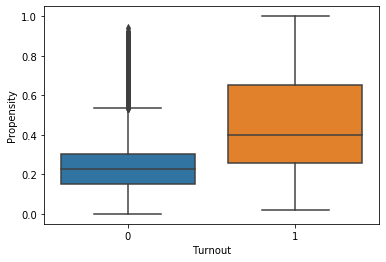

In [386]:
ax = sns.boxplot(x="Turnout", y="Propensity", data=learner_df[learner_df.Treatment==0])

In [547]:
pd.Series(np.where(learner_df.Propensity>0.4, 0,
                   np.where(learner_df.Propensity+learner_df.ITE<0.4, 0, 1))).value_counts()

0    186885
1      1601
dtype: int64

In [549]:
learner_df['distance']=np.where(learner_df.Propensity>0.4, -1,learner_df.Propensity+learner_df.ITE-0.4)

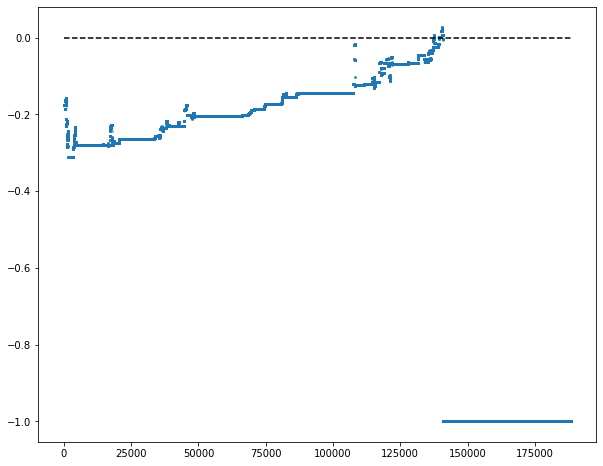

In [550]:
plt.figure(figsize=(10, 8))
plt.scatter(learner_df.index, learner_df.distance, alpha=0.3, s=3) 
plt.hlines(y=0, xmin=0.0, xmax=188486.0,
           colors='black', linestyles='dashed')


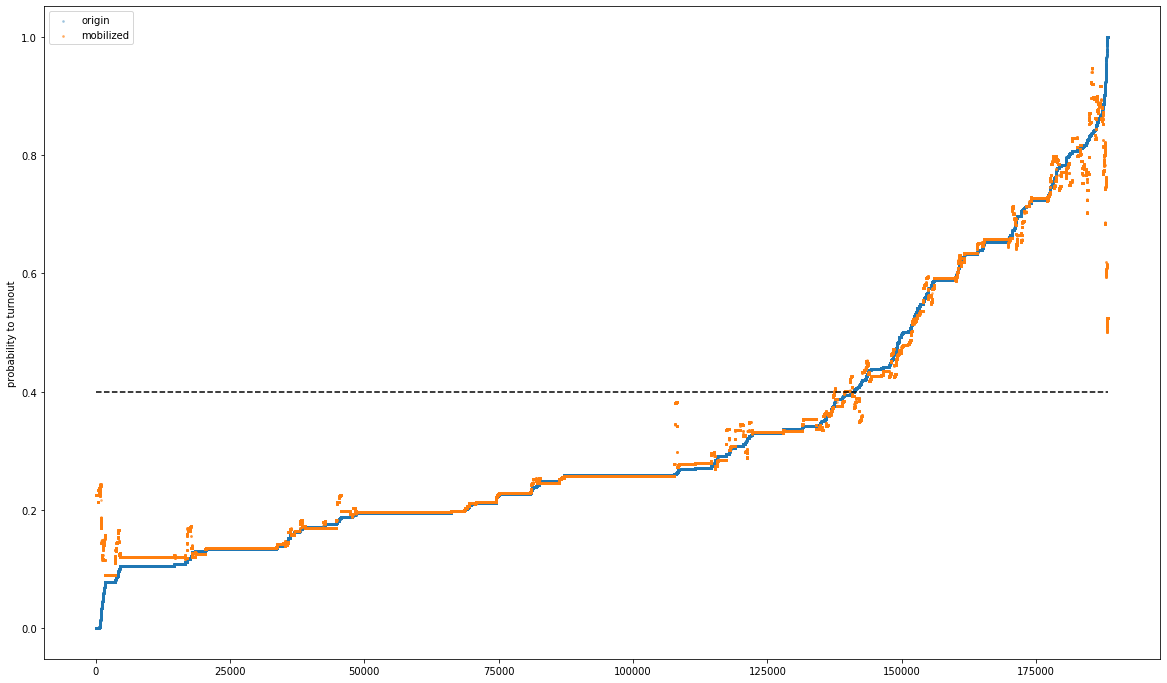

In [551]:
plt.figure(figsize=(20, 12))

plt.scatter(learner_df.index, learner_df.Propensity, label="origin", alpha=0.3, s=3) 
plt.scatter(learner_df.index, learner_df.Propensity+learner_df.ITE, label="mobilized", alpha=0.5, s=3) 
plt.hlines(y=0.4, xmin=0.0, xmax=188486,
           colors='black', linestyles='dashed')
plt.xlabel('')
plt.ylabel('probability to turnout')
plt.legend()
plt.show()

In [22]:
import matplotlib.pylab as pylab
params = {
        'axes.labelsize': '18',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

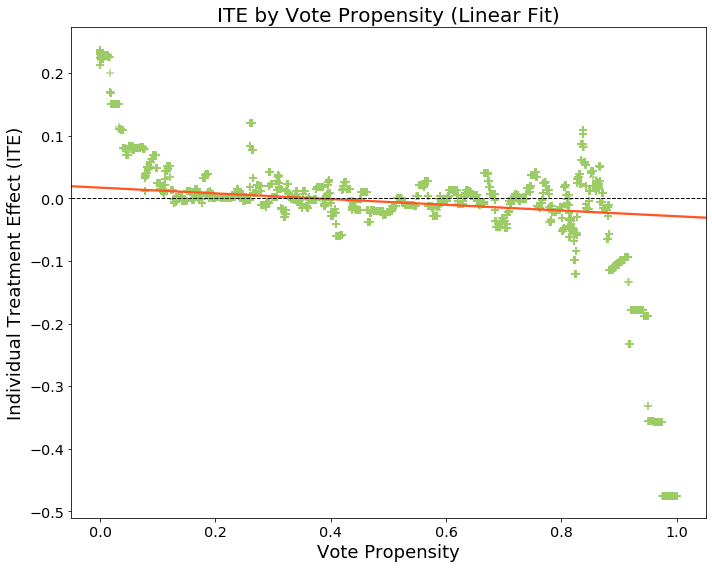

In [23]:
plt.figure(figsize=(10, 8))
ax = sns.regplot(x='Propensity', y='ITE',
                 data=learner_df, 
                 order=1,
                 ci=100, 
                 marker="+",
                 scatter_kws={'color':'#9CCC65',"s": 50}, 
                 line_kws={'color':'#FF5722'})
ax.axhline(y = 0, color='black', linewidth=1, alpha=2,ls='--')
plt.xlabel("Vote Propensity")
plt.ylabel("Individual Treatment Effect (ITE)")

plt.title('ITE by Vote Propensity (Linear Fit)',
          {'fontsize': 20,
        'fontweight' : 5})
plt.tight_layout()
plt.savefig('NGA IL with Line', dpi=800)

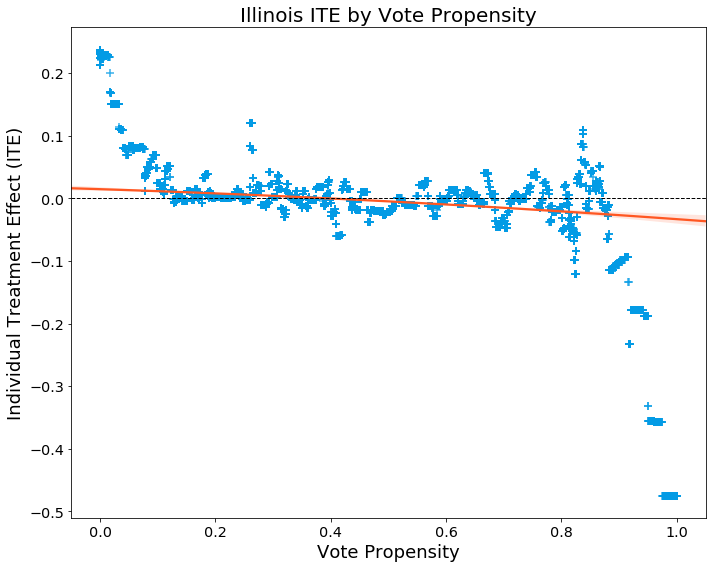

In [24]:
plt.figure(figsize=(10, 8))
ax = sns.regplot(x='Propensity', y='ITE',
                 data=learner_df, 
                 order=2,
                 ci=100, 
                 marker="+",
                 scatter_kws={'color':'#039be5',"s": 50}, 
                 line_kws={'color':'#FF5722'})
ax.axhline(y = 0, color='black', linewidth=1, alpha=2,ls='--')

plt.xlabel("Vote Propensity")
plt.ylabel("Individual Treatment Effect (ITE)")

plt.title('Illinois ITE by Vote Propensity',
          {'fontsize': 20,
        'fontweight' : 5})
plt.tight_layout()
plt.savefig('NGA IL with Parabola', dpi=800)

### Sigmoid Fit

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def sigmoid(x, a, b, c, d):
    # a adjusts amplitude
    # b adjusts y offset
    # c adjusts x offset
    # d adjusts slope
    return ((a - b) / (1. + np.exp(x - (c / 2)) ** d)) + b


xdata = np.array(learner_df.Propensity)
ydata = np.array(learner_df.ITE)


p0 = [max(ydata), min(ydata),max(xdata), 1]

# fit the data
popt, pcov = curve_fit(sigmoid, xdata, ydata, p0)


In [27]:
np.set_printoptions(suppress=True) #prevent numpy exponential 
                                   #notation on print, default False

In [28]:
popt

array([ 0.00392146, -0.51692097,  1.88561321, 43.01471799])

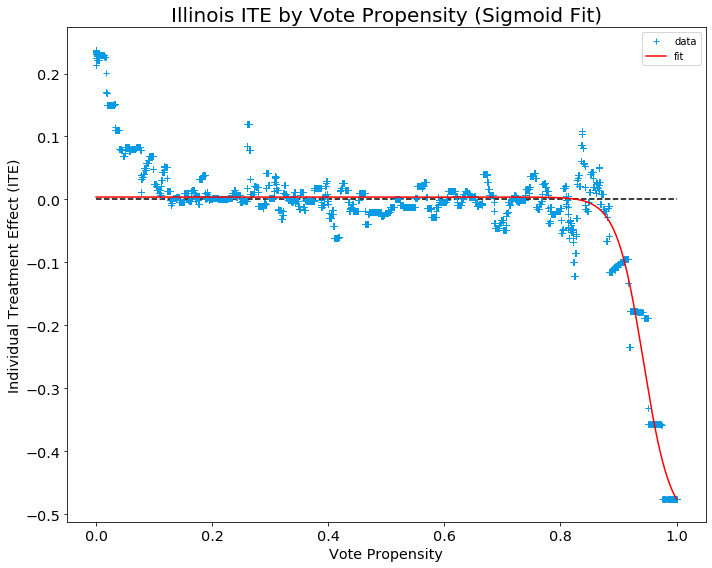

In [52]:
plt.figure(figsize=(10, 8))
# plot data
plt.plot(xdata, ydata, '+',c='#039be5',label='data')


# plot the result
xdata_new = np.linspace(0, 1, 1000)
plt.plot(xdata_new, sigmoid(xdata_new, *popt), 'r-', label='fit')
plt.hlines(y=0, xmin=0.0, xmax=1.0,
           colors='black', linestyles='dashed')
plt.legend(loc='best')
plt.xlabel("Vote Propensity")
plt.ylabel("Individual Treatment Effect (ITE)")

plt.title('Illinois ITE by Vote Propensity (Sigmoid Fit)',
          {'fontsize': 20,
        'fontweight' : 5})
plt.tight_layout()
plt.show()

In [30]:
X = learner_df[['Propensity']]
X = sm.add_constant(X)

In [31]:
from sklearn.metrics import mean_squared_error

In [42]:
min(sigmoid(xdata, *popt))

-0.47593124508470125

In [32]:
ols_mse = mean_squared_error(ydata, np.array(ols.predict(X)))
sig_mes = mean_squared_error(ydata, np.array(sigmoid(xdata, *popt)))

In [39]:
ols2_mse = mean_squared_error(ydata, np.array(ols2.predict(X)))

In [33]:
'linear fit MSE: {:.6f}'.format(ols_mse)

'linear fit MSE: 0.000963'

In [40]:
'linear2 fit MSE: {:.6f}'.format(ols2_mse)

'linear2 fit MSE: 0.000963'

In [34]:
'Sigmoid fit MSE: {:.6f}'.format(sig_mes)

'Sigmoid fit MSE: 0.000529'

In [41]:
'Sigmoid fit reduce MSE by {:.2%}'.format(1-sig_mes/ols2_mse)

'Sigmoid fit reduce MSE by 45.04%'

In [35]:
'Sigmoid fit reduce MSE by {:.2%}'.format(1-sig_mes/ols_mse)

'Sigmoid fit reduce MSE by 45.07%'

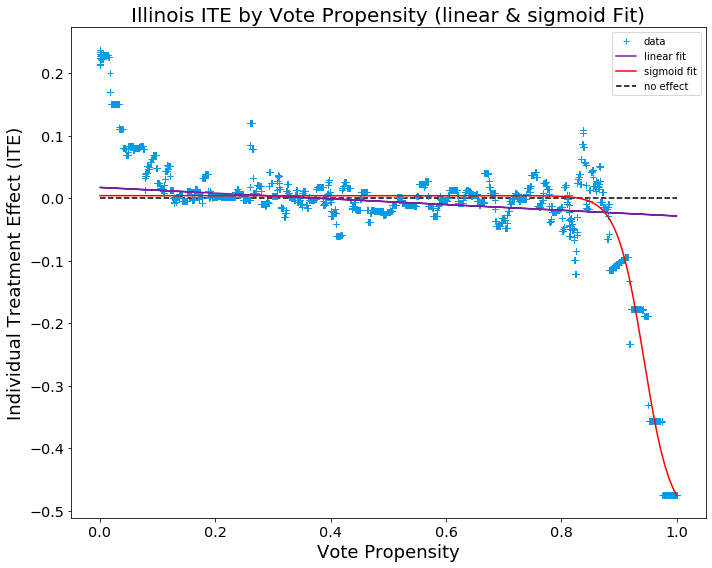

In [36]:
plt.figure(figsize=(10, 8))
# plot data
plt.plot(xdata, ydata, '+',c='#039be5',label='data')

# plot linear fit
plt.plot(xdata, np.array(ols.predict(X)), '-',c='#7b1fa2', label='linear fit')

# plot sigmoid fit
xdata_new = np.linspace(0, 1, 1000)
plt.plot(xdata_new, sigmoid(xdata_new, *popt), 'r-', label='sigmoid fit')

plt.hlines(y=0, xmin=0.0, xmax=1.0,
           colors='black', linestyles='dashed', label = 'no effect')
plt.legend(loc='best')
plt.xlabel("Vote Propensity")
plt.ylabel("Individual Treatment Effect (ITE)")

plt.title('Illinois ITE by Vote Propensity (linear & sigmoid Fit)',
          {'fontsize': 20,
        'fontweight' : 5})
plt.tight_layout()
plt.savefig('NGA IL with both fit', dpi=800)
plt.show()

# Simulation

In [4]:
learner_df = pd.read_csv('../../Machine Learing HTE/1_data/nga_il/NGA_IL_with_ITEs.csv')

In [5]:
learner_df.head()

,Propensity,ITE,Treatment,Turnout,hh_id,Propensity Range,Propensity_square
0,0.160607,-0.002783,1,0,61153.0,"(0.1, 0.2]",0.025795
1,0.077664,0.012406,1,0,160473.0,"(0.0, 0.1]",0.006032
2,1.000000,-0.474798,1,0,137591.0,"(0.9, 1.0]",1.000000
3,0.138696,0.004291,0,1,11275.0,"(0.1, 0.2]",0.019237
4,0.282955,-0.009993,1,0,52014.0,"(0.2, 0.3]",0.080064


In [563]:
sim = learner_df.sort_values('distance',ascending=False ).reset_index(drop=True)

In [6]:
sim = learner_df.sort_values('Propensity').reset_index(drop=True)

In [8]:
sim.tail()

,Propensity,ITE,Treatment,Turnout,hh_id,Propensity Range,Propensity_square
188481,1.0,-0.474798,1,1,18135.0,"(0.9, 1.0]",1.0
188482,1.0,-0.474798,1,0,5476.0,"(0.9, 1.0]",1.0
188483,1.0,-0.474798,1,0,137591.0,"(0.9, 1.0]",1.0
188484,1.0,-0.474798,1,0,123580.0,"(0.9, 1.0]",1.0
188485,1.0,-0.474798,1,1,152581.0,"(0.9, 1.0]",1.0


In [9]:
sim.Treatment.value_counts()

1    94257
0    94229
Name: Treatment, dtype: int64

In [10]:
sim.loc[0:94257,'sim_treat'] = 1

In [11]:
sim.loc[94257:,'sim_treat'] = 0

In [570]:
sim['sim_result'] = sim.Propensity+sim.sim_treat*sim.ITE

In [571]:
sim['result'] = sim.Propensity+sim.Treatment*sim.ITE

In [587]:
pd.crosstab(sim.Turnout, np.where(sim['result']>0.3,1,0))

col_0,0,1
Turnout,,
0,94775,32681
1,22792,38238


In [538]:
pd.crosstab(sim.Turnout, np.where(sim['result']>0.4,1,0))

col_0,0,1
Turnout,,
0,109981,17475
1,30915,30115


In [12]:
X = sim[['sim_treat']]

X = sm.add_constant(X)

y =  sim['ITE']

In [13]:
sm_az = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': sim['hh_id']})

In [14]:
X = sim[['Treatment']]

X = sm.add_constant(X)

y =  sim['ITE']


In [15]:
ite_il = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': sim['hh_id']})

In [18]:
# display and export regression table
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
from IPython.display import Latex

In [33]:
stargazer = Stargazer([ite_il,sm_az])
stargazer.significant_digits(4)
stargazer.title('ITE vs Simulation (NextGen Climate)')
stargazer.covariate_order(['const',  'Treatment','sim_treat'])

stargazer.rename_covariates({'const': 'Intercept',
                            'sim_treat': 'Optimized Alloaction'})


stargazer.custom_columns(['Treatment Assignment', 'Optimized'], [1,1])
HTML(stargazer.render_html())

In [34]:
Latex(stargazer.render_latex())

<IPython.core.display.Latex object>

In [ ]:
result = learner_df.Propensity+learner_df.Propensity

In [94]:
learner_df.columns

Index(['Propensity', 'ITE', 'Treatment', 'Turnout', 'hh_id',
       'Propensity Range', 'Propensity_square'],
      dtype='object')